# Algoritmo de GradCAM para PyTorch aplicada en imágenes de cerebros con diferentes diagnósticos de Alzheimer.

In [ ]:
import sys
def in_colab():
    "Check if the code is running in Google Colaboratory"
    return 'google.colab' in sys.modules

In [3]:
if in_colab():
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Empezamos con las importaciones:**

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from skimage.io import imread
from skimage.transform import resize

# Modelo

**Vamos a usar ganchos para obtener los mapas de activación y los gradientes de la capa y el tensor deseados, respectivamente. Para este tutorial vamos a tomar los mapas de activación de la capa 4 de ResNet50 y gradientes con respecto al tensor de salida de la misma**.

In [94]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out

**Declaramos la instancia de Modelo.**

In [95]:
gcmodel = GradCamModel().to('cuda:0')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Leemos la imagen.**

In [85]:
img = imread('/content/drive/MyDrive/Imagenes Cerebro/Imagenes modelo/VeryMildDemented/21270.jpg')
img = resize(img, (224,224), preserve_range = True)
img = np.expand_dims(img.transpose((2,0,1)),0)
img /= 255.0
mean = np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
std = np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
img = (img - mean)/std
inpimg = torch.from_numpy(img).to('cuda:0', torch.float32)

**Compute Gradient Class Activation Maps.**

In [86]:
out, acts = gcmodel(inpimg)
acts = acts.detach().cpu()
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([600])).to('cuda:0'))
loss.backward()
grads = gcmodel.get_act_grads().detach().cpu()
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()
for i in range(acts.shape[1]):
 acts[:,i,:,:] += pooled_grads[i]
heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max

**Resize Heatmap**

In [87]:
heatmap_j = resize(heatmap_j,(224,224),preserve_range=True)

**Colour Mapping**

In [88]:
cmap = mpl.cm.get_cmap('jet',256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.2)

**Plotting y resultados**

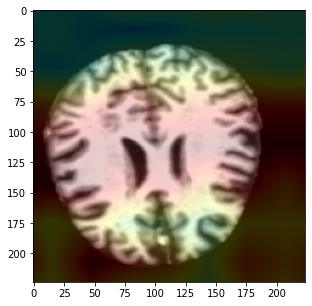

In [89]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow((img*std+mean)[0].transpose(1,2,0))
axs.imshow(heatmap_j2)
plt.show()

**Otro tipo de Visualización de Gradcam**

In [90]:
heatmap_j3 = (heatmap_j > 0.75)

**Plotting y resultados**

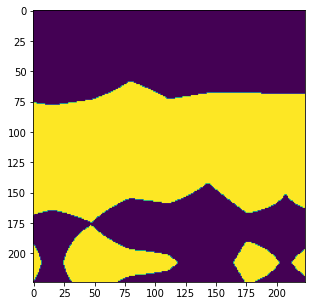

In [91]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(((img*std+mean)[0].transpose(1,2,0)))
axs.imshow(heatmap_j3)
plt.show()